In [87]:
import pandas as pd
from pathlib import Path
import os
import json
import matplotlib.pyplot as plt
import numpy as np


mobilenet_folder = '../MobileNet/evaluations/saves/MobileNetV2WithExits/2023-08-20-05-20-25/epoch_19_89.7_90.9.pth'
alexnet_folder = '../AlexNet/evaluations/saves/2023-08-20-01-53-10/epoch_19_90.2_91.3.pth'



In [145]:
def process_data(dfs, network_name, min_cnf=[0.9, 0.9, 0.): 

    data = {
        'network' : network_name,
        'min_cnf' : min_cnf,
        'labels' : [],
        'exit1_rate' : [],
        'exit1_accuracy' : [],
        'exit2_accuracy' : [],
        'model_accuracy' : [],
        'model_avg_time' : [],
        'exit1_standalone_accuracy' : [],
        'exit2_standalone_accuracy' : [],
        'exit1_standalone_avg_time' : [],
        'exit2_standalone_avg_time' : [],
    }

    for year in range(2016, 2020):
        year = f'{year:04d}'
        for month in range(1, 13):
            month = f'{month:02d}'

            df = dfs[year][month]

            exit1_accuracy = float('nan')
            exit2_accuracy = float('nan')

            exit1 = df.query(f'cnf_exit_1 >= {min_cnf}')
            exit1_correct = exit1.query('y == y_exit_1')

            if exit1['y'].count() > 0:
                exit1_accuracy = exit1_correct['y'].count() / exit1['y'].count()

            exit1_rate = exit1['y'].count() / df['y'].count()

            exit2 = df.query(f'cnf_exit_1 < {min_cnf}')
            exit2_correct = exit2.query('y == y_exit_2')

            if exit2['y'].count() > 0:
                exit2_accuracy = exit2_correct['y'].count() / exit2['y'].count()

            model_accuracy = ( exit1_correct['y'].count() + exit2_correct['y'].count() ) / df['y'].count()
            model_avg_time = ( df['bb_time_exit_1'].sum() + exit1['exit_time_exit_1'].sum() +
                               exit2['bb_time_exit_2'].sum() + exit2['exit_time_exit_2'].sum() ) / df['y'].count()
                

            exit1_standalone_accuracy = df.query('y == y_exit_1')['y'].count() / df['y'].count()
            exit2_standalone_accuracy = df.query('y == y_exit_2')['y'].count() / df['y'].count()
            exit1_standalone_avg_time = ( df['bb_time_exit_1'].sum() + df['exit_time_exit_1'].sum() ) / df['y'].count()
            exit2_standalone_avg_time = ( df['bb_time_exit_1'].sum() + df['bb_time_exit_2'].sum() +
                                          df['exit_time_exit_2'].sum() ) / df['y'].count()

            data['labels'].append(f'{year}_{month}')
            data['exit1_rate'].append(exit1_rate)
            data['exit1_accuracy'].append(exit1_accuracy)
            data['exit2_accuracy'].append(exit2_accuracy)
            data['model_accuracy'].append(model_accuracy)
            data['model_avg_time'].append(model_avg_time)
            data['exit1_standalone_accuracy'].append(exit1_standalone_accuracy)
            data['exit2_standalone_accuracy'].append(exit2_standalone_accuracy)
            data['exit1_standalone_avg_time'].append(exit1_standalone_avg_time)
            data['exit2_standalone_avg_time'].append(exit2_standalone_avg_time)

            '''
            print(f"Running the analysis for {year}_{month}")
            print(f'Pickup rate for exit1: {100*exit1_rate:.2f}%')
            print(f'Accuracy for exit1: {100*exit1_accuracy:.2f}%')
            print(f'Accuracy for exit2: {100*exit2_accuracy:.2f}%')
            print(f'Model Accuracy: {100*model_accuracy:.2f}%')
            print(f'Model Average time: {1e6*model_avg_time:.2f}us')
            print('')
            print(f'Accuracy for exit1_standalone: {100*exit1_standalone_accuracy:.2f}%')
            print(f'Accuracy for exit2_standalone: {100*exit2_standalone_accuracy:.2f}%')
            print(f'Average time for exit1_standalone: {1e6*exit1_standalone_avg_time:.2f}us')
            print(f'Average time for exit2_standalone: {1e6*exit2_standalone_avg_time:.2f}us')
            print("\n\n")
            '''
    return data
    #print(json.dumps(data, indent=2))

def plot(data):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout='constrained')
    fig.autofmt_xdate(rotation=90)
    plt.title(f"Accuracy {data['network']} - min cnf: {data['min_cnf']}")

    axs[0].plot(data['labels'], data['exit1_rate'], label='exit1_rate')
#    axs[0].plot(data['exit1_accuracy'], label='exit1_accuracy (when picked)')
#    axs[0].plot(data['exit2_accuracy'], label='exit2_accuracy (when picked)')
    axs[0].plot(data['model_accuracy'], label='model_accuracy')
    axs[0].plot(data['exit1_standalone_accuracy'], label='exit1_standalone_accuracy')
    axs[0].plot(data['exit2_standalone_accuracy'], label='exit2_standalone_accuracy')
    axs[0].legend()

    axs[1].plot(data['labels'], data['model_avg_time'], label='model_avg_time')
    axs[1].plot(data['exit1_standalone_avg_time'], label='exit1_standalone_avg_time')
    axs[1].plot(data['exit2_standalone_avg_time'], label='exit2_standalone_avg_time')
    axs[1].legend()
    
    plt.show

In [139]:
# directory = alexnet_folder
directory = mobilenet_folder
files = Path(directory).glob('*.csv')

mobilenet_dfs = {}

for year in range(2016, 2020):
    year = f'{year:04d}'
    for month in range(1, 13):
        month = f'{month:02d}'
        glob = f'{year}_{month}'
        csv = os.path.join(directory, f'{glob}.csv')
        if year not in mobilenet_dfs:
            mobilenet_dfs[year] = {}
        mobilenet_dfs[year][month] = pd.read_csv(csv)

/tmp/ipykernel_368859/4059968080.py:83: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=90)


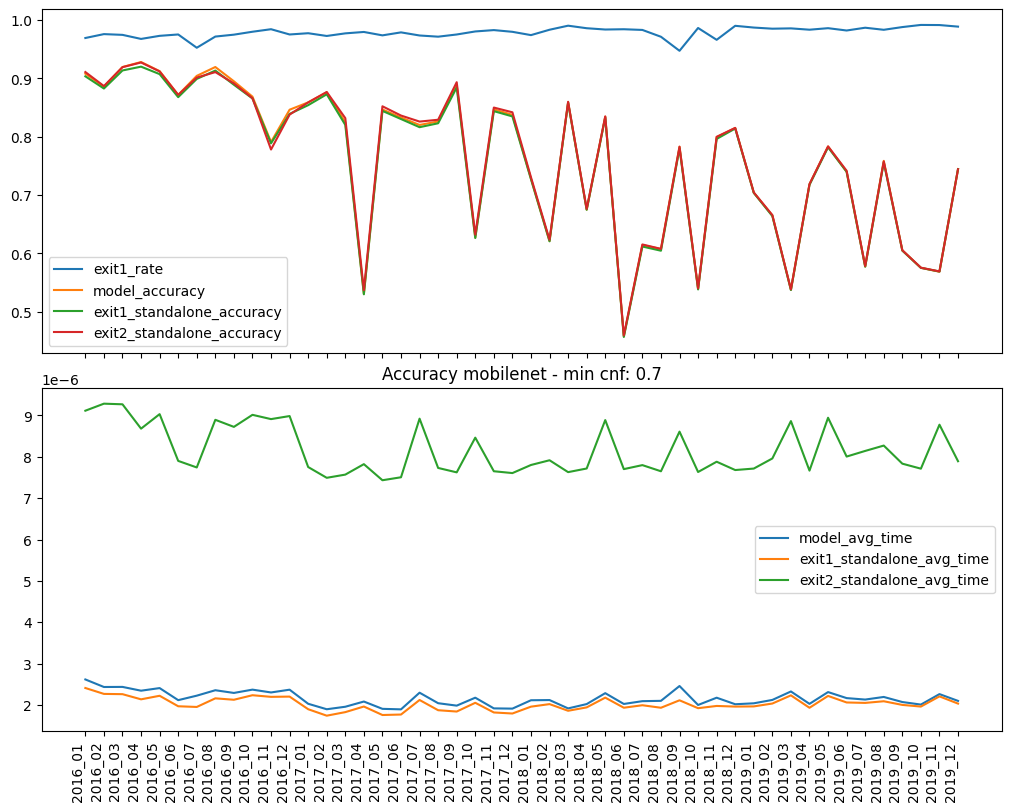

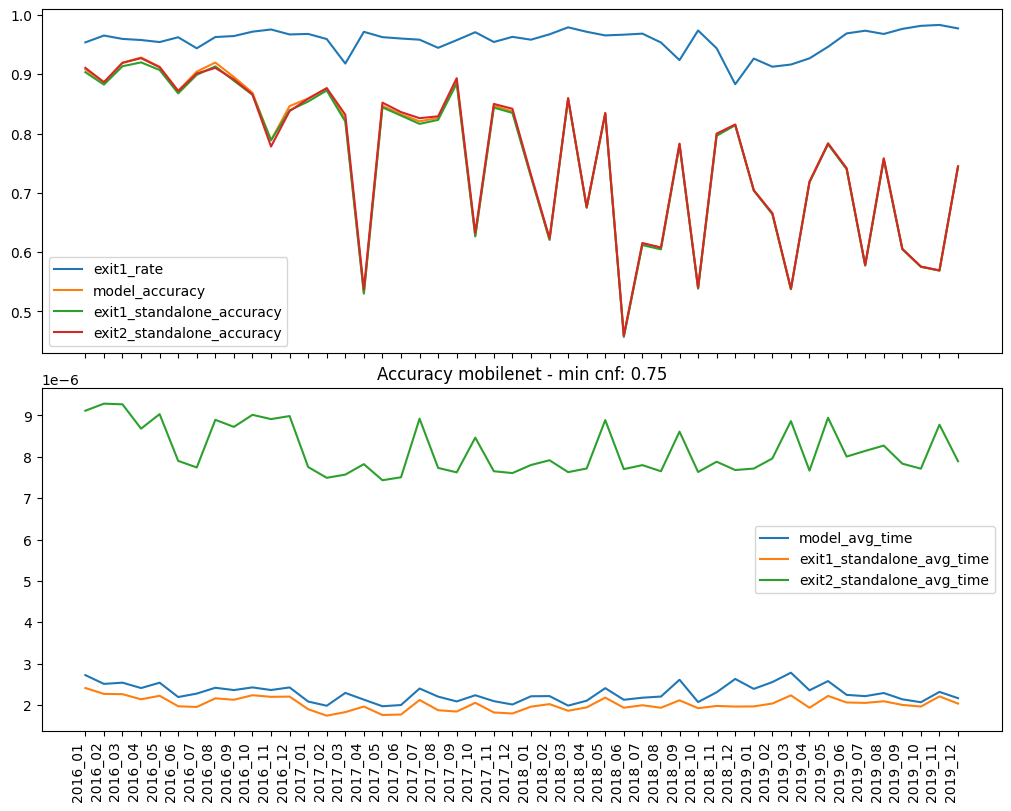

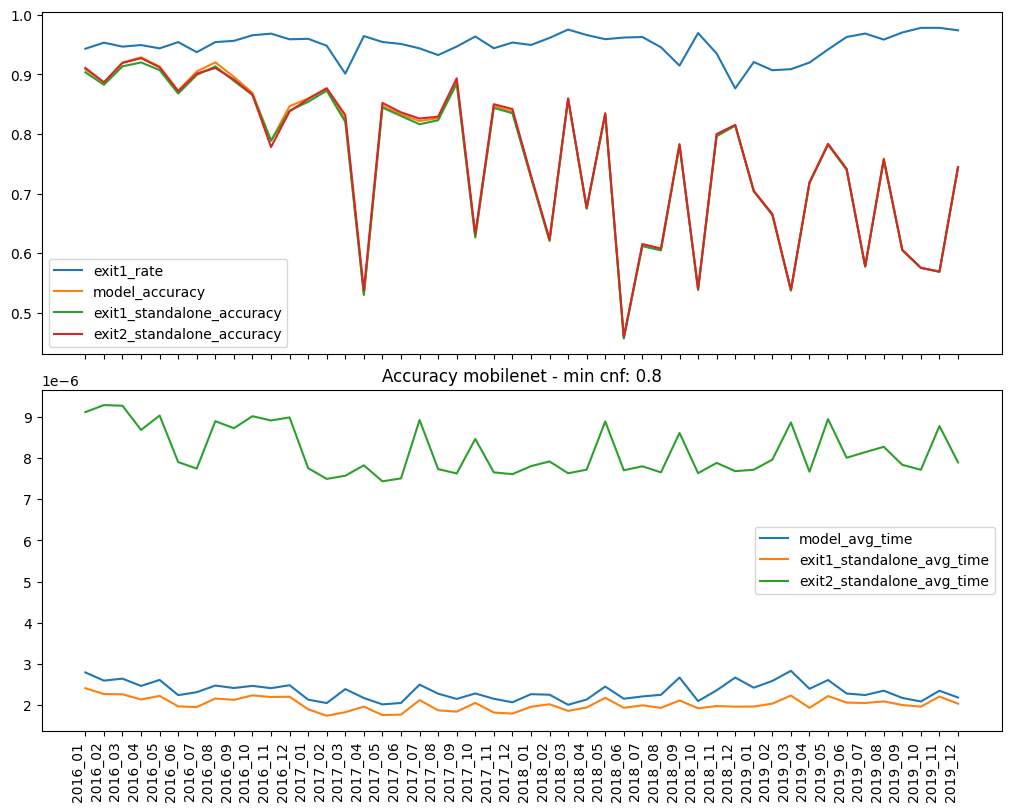

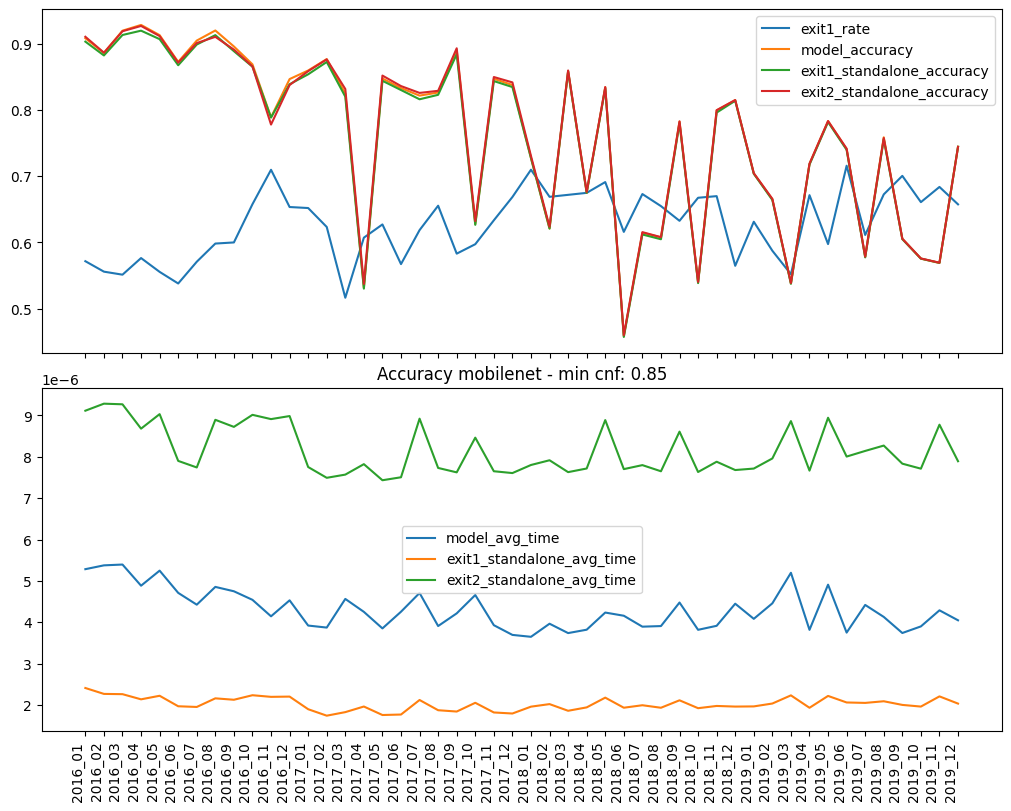

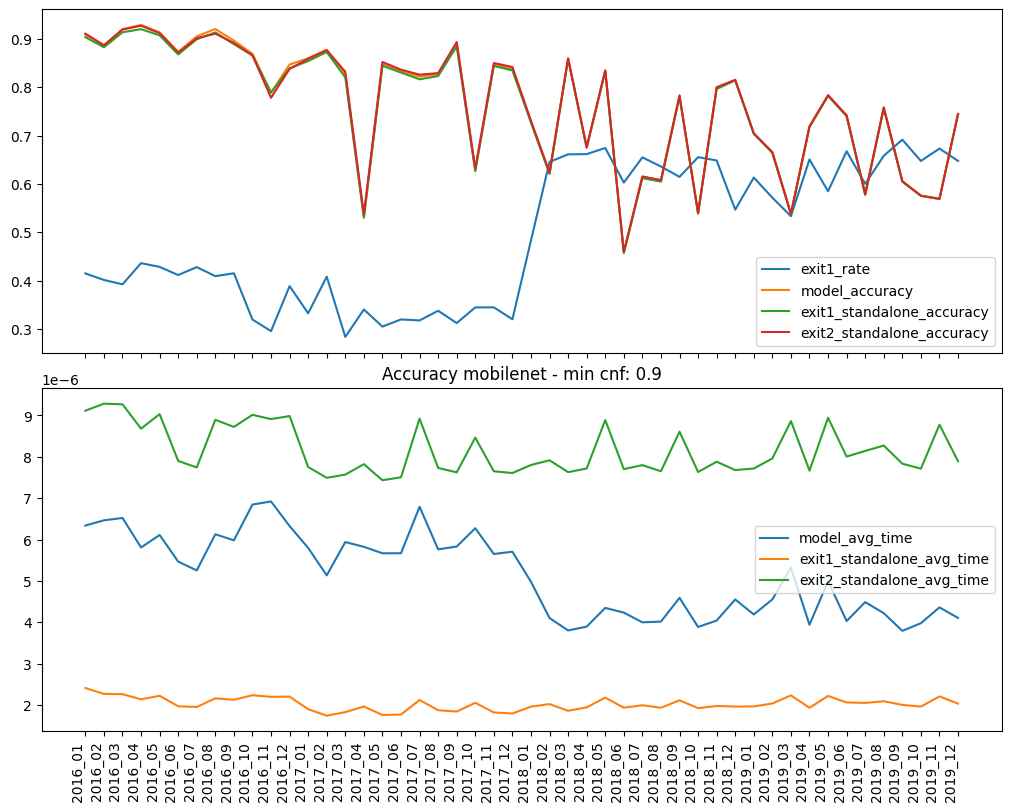

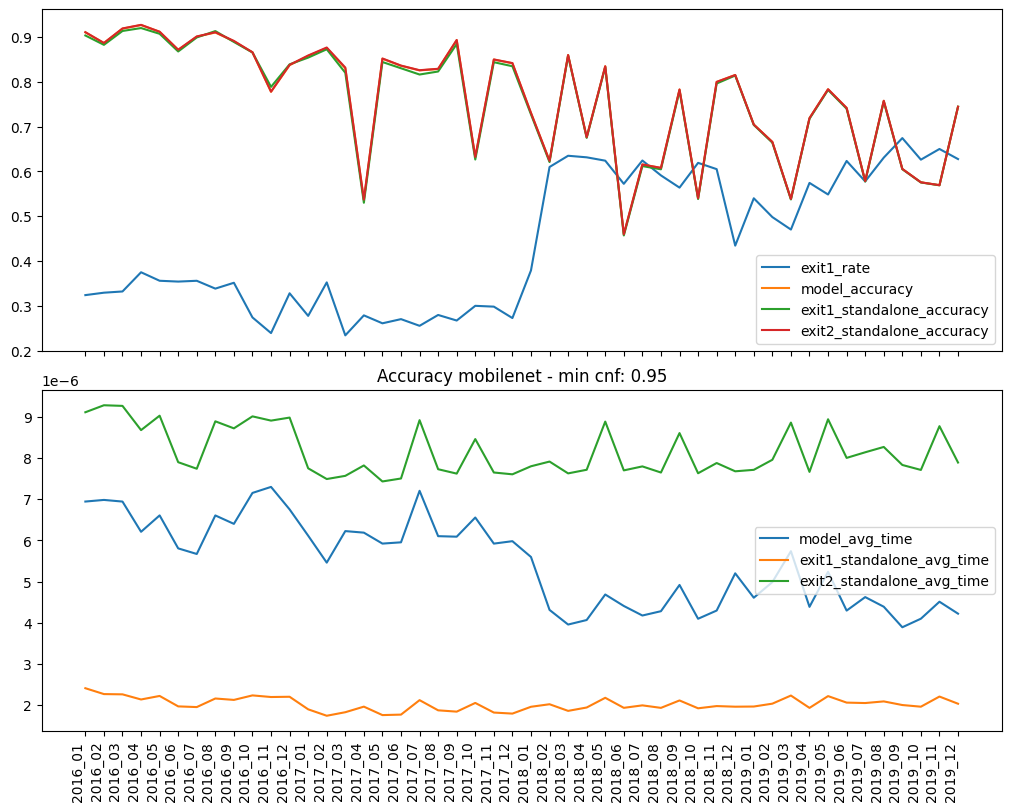

In [146]:
for cnf in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    data = process_data(mobilenet_dfs, 'mobilenet', min_cnf=cnf)
    plot(data)

In [141]:
directory = alexnet_folder
# directory = mobilenet_folder
files = Path(directory).glob('*.csv')

alexnet_dfs = {}

for year in range(2016, 2020):
    year = f'{year:04d}'
    for month in range(1, 13):
        month = f'{month:02d}'
        glob = f'{year}_{month}'
        csv = os.path.join(directory, f'{glob}.csv')
        if year not in alexnet_dfs:
            alexnet_dfs[year] = {}
        alexnet_dfs[year][month] = pd.read_csv(csv)

/tmp/ipykernel_368859/4059968080.py:83: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=90)


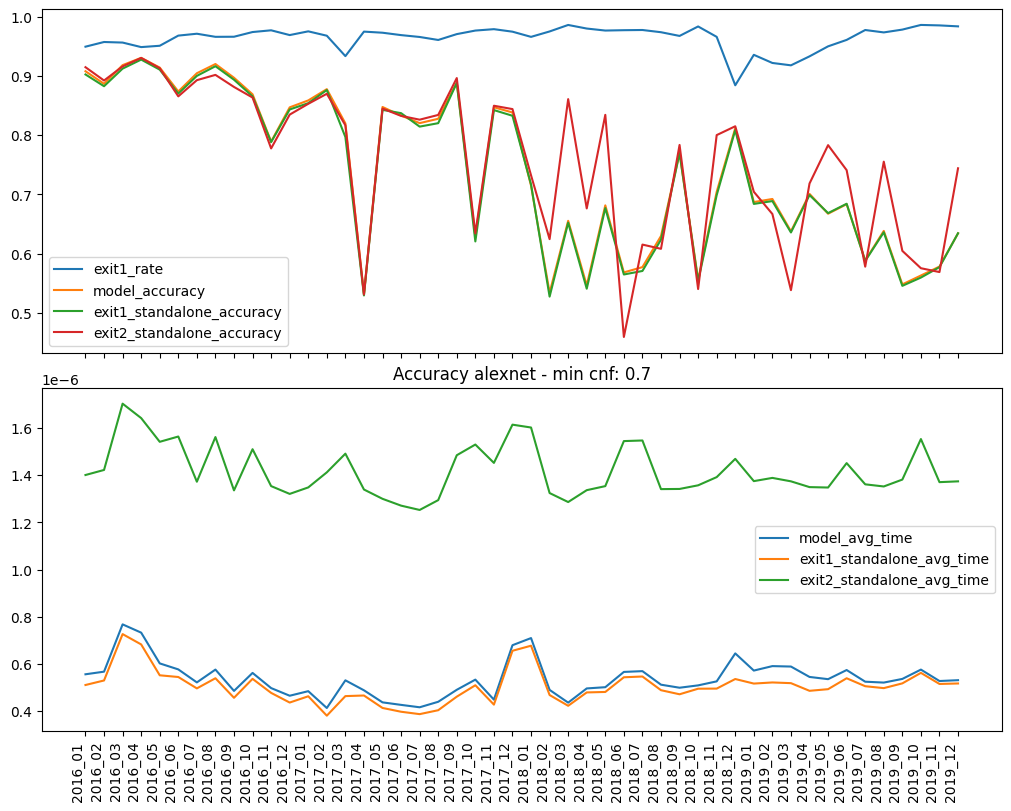

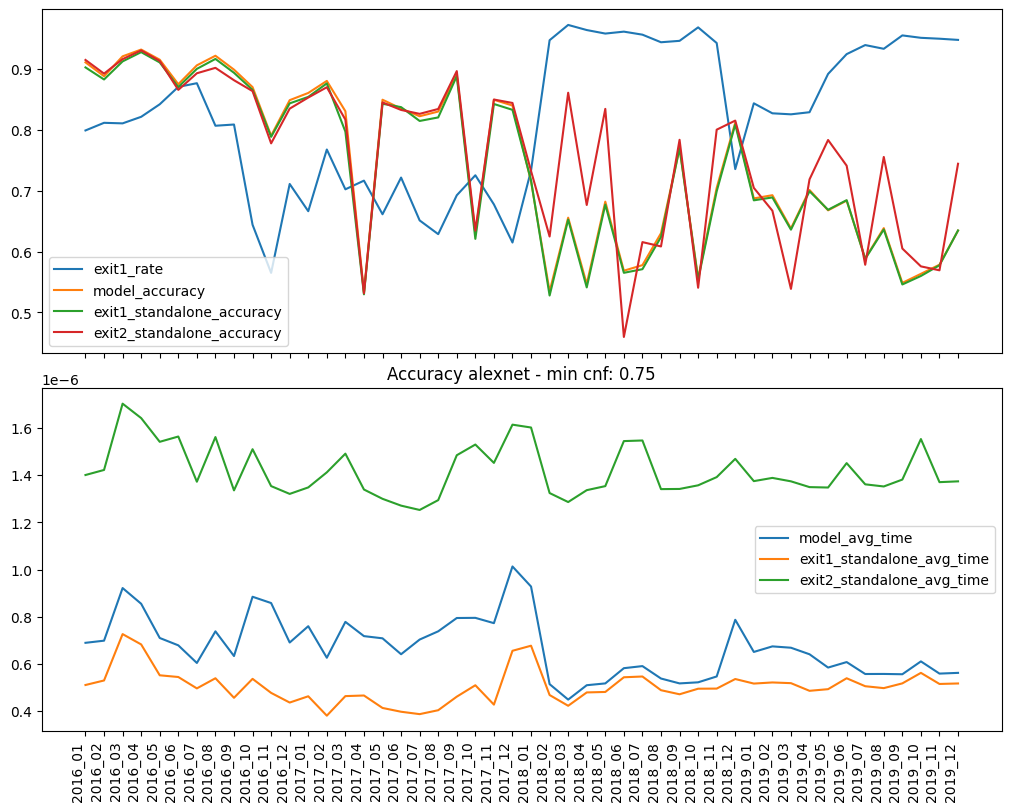

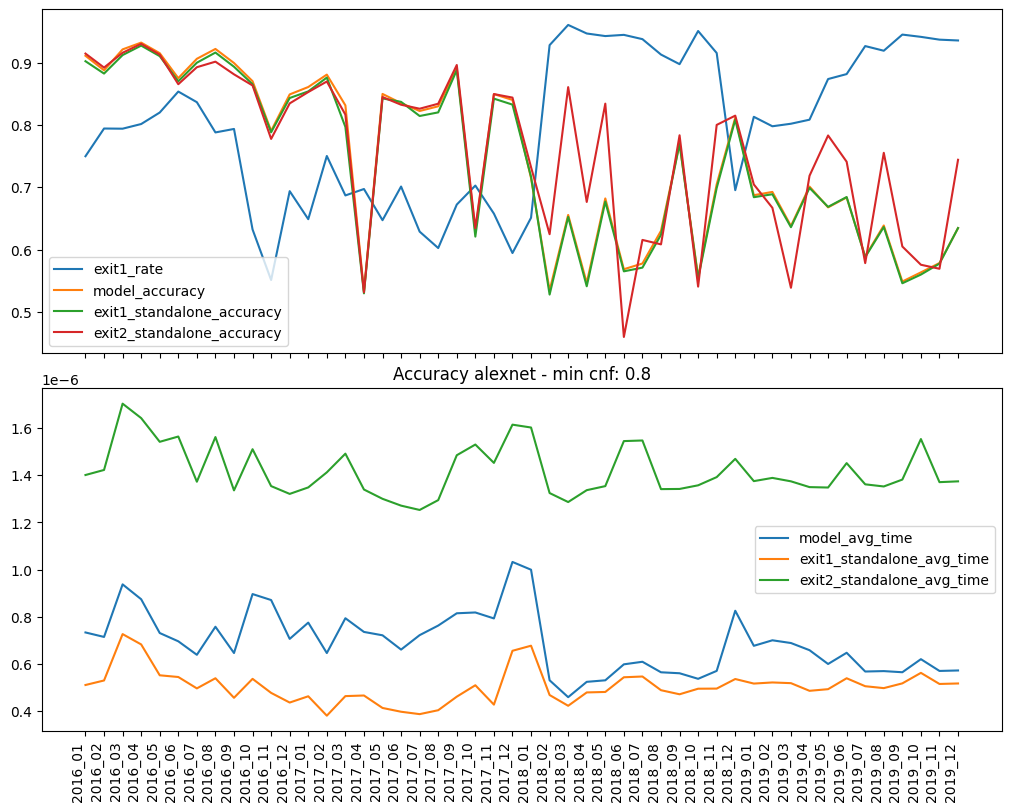

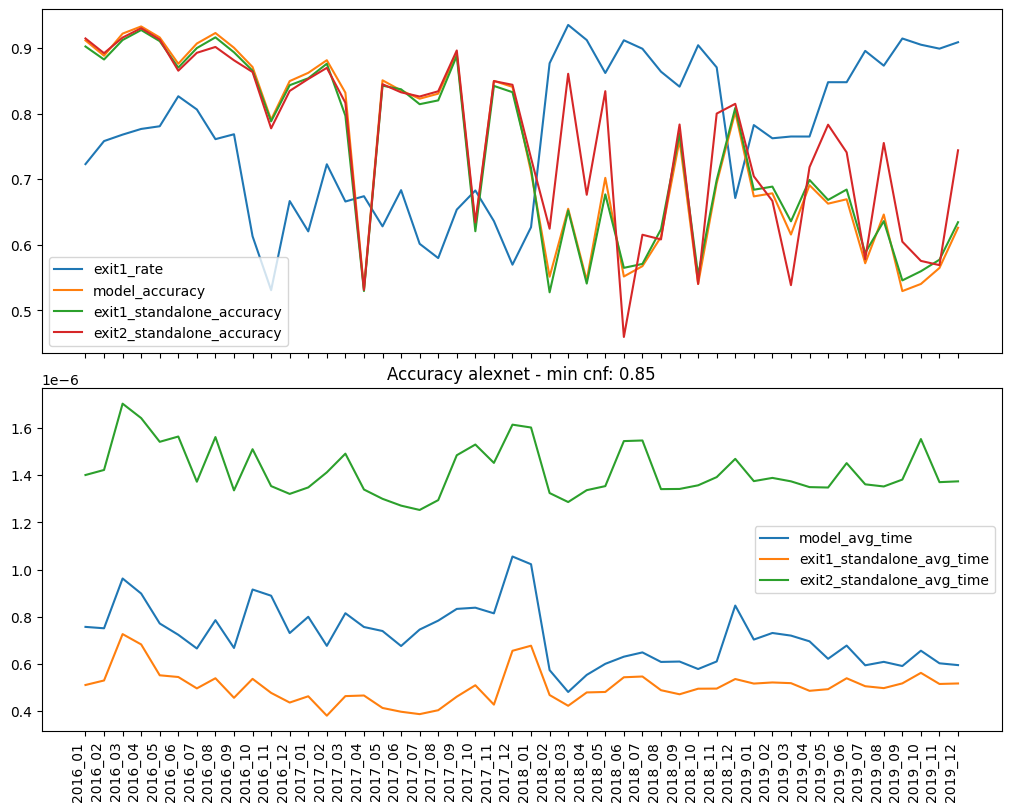

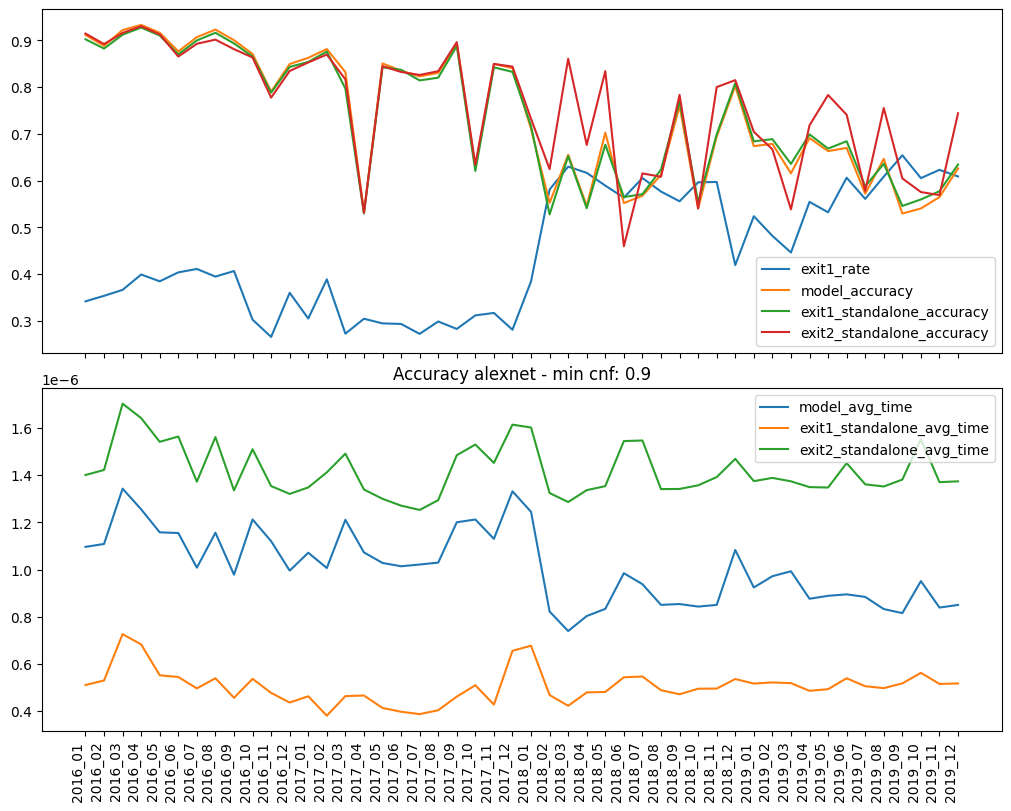

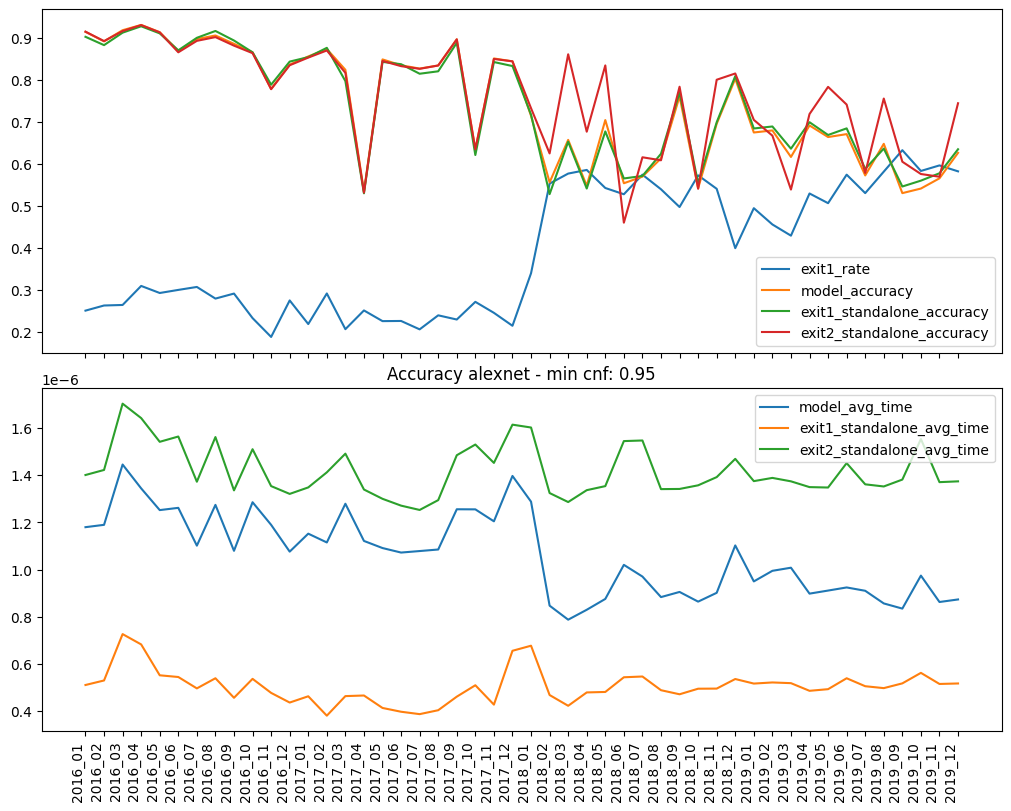

In [147]:
for cnf in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    data = process_data(alexnet_dfs, 'alexnet', min_cnf=cnf)
    plot(data)

In [150]:
directory = '../AlexNet/evaluations/saves/2023-08-20-01-53-10/epoch_10_80.9_90.8.pth'
files = Path(directory).glob('*.csv')

alexnet_dfs = {}

for year in range(2016, 2020):
    year = f'{year:04d}'
    for month in range(1, 13):
        month = f'{month:02d}'
        glob = f'{year}_{month}'
        csv = os.path.join(directory, f'{glob}.csv')
        if year not in alexnet_dfs:
            alexnet_dfs[year] = {}
        alexnet_dfs[year][month] = pd.read_csv(csv)

/tmp/ipykernel_368859/4059968080.py:83: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=90)


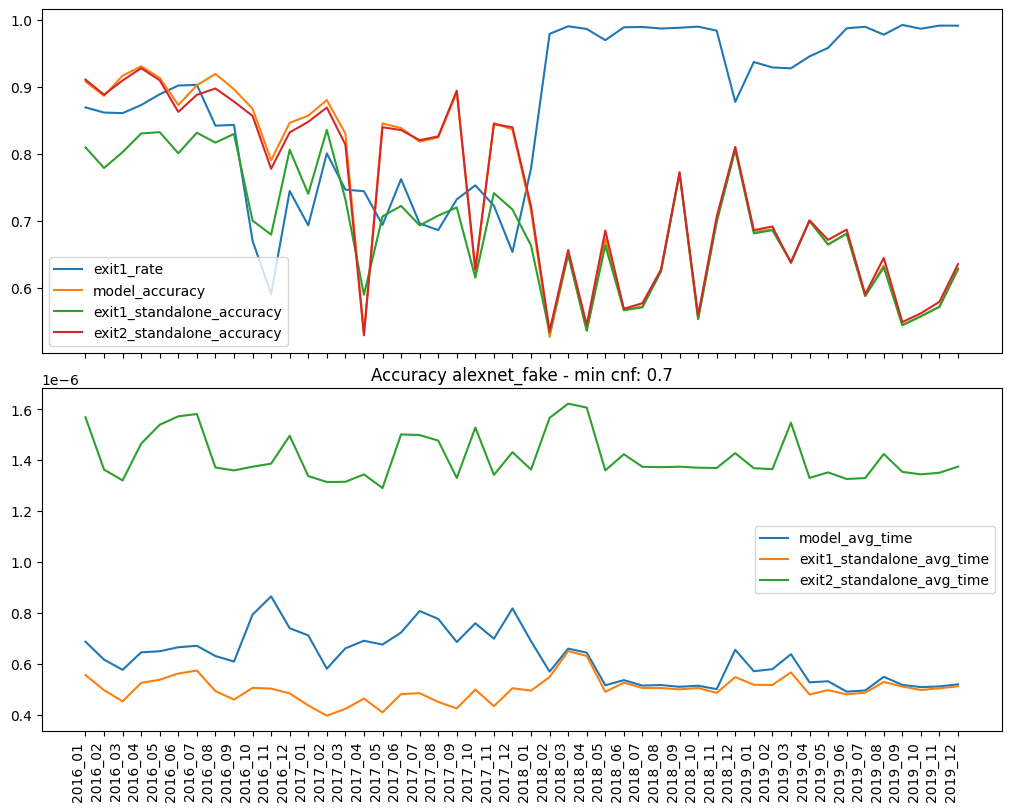

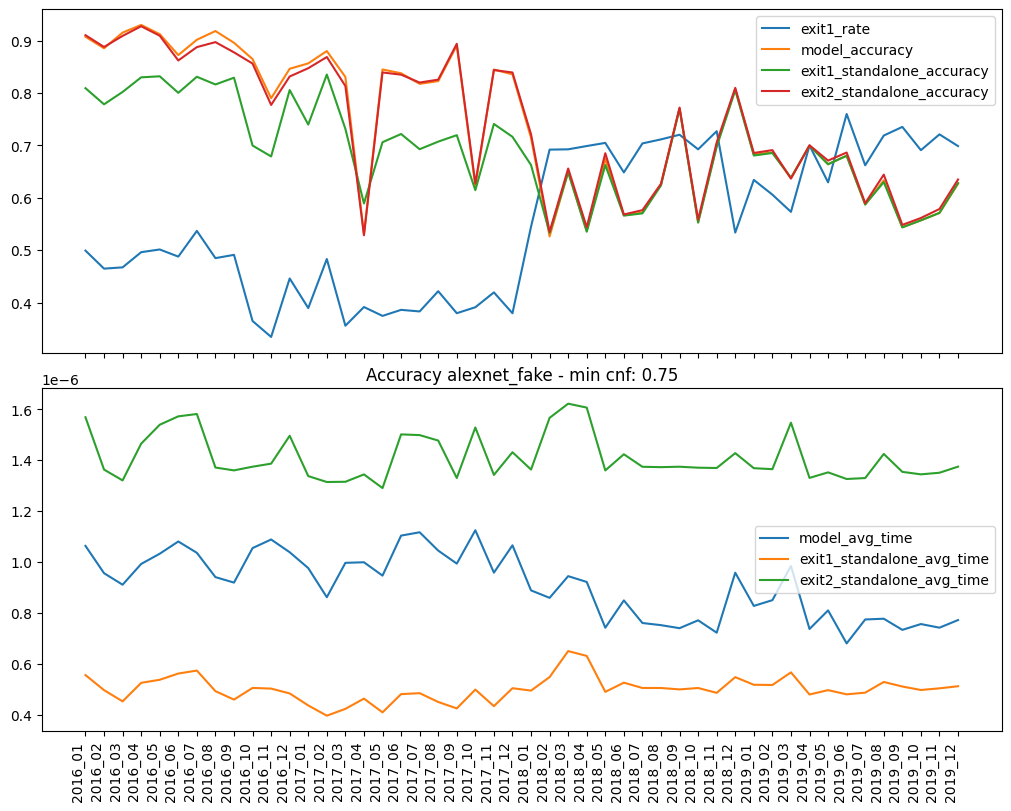

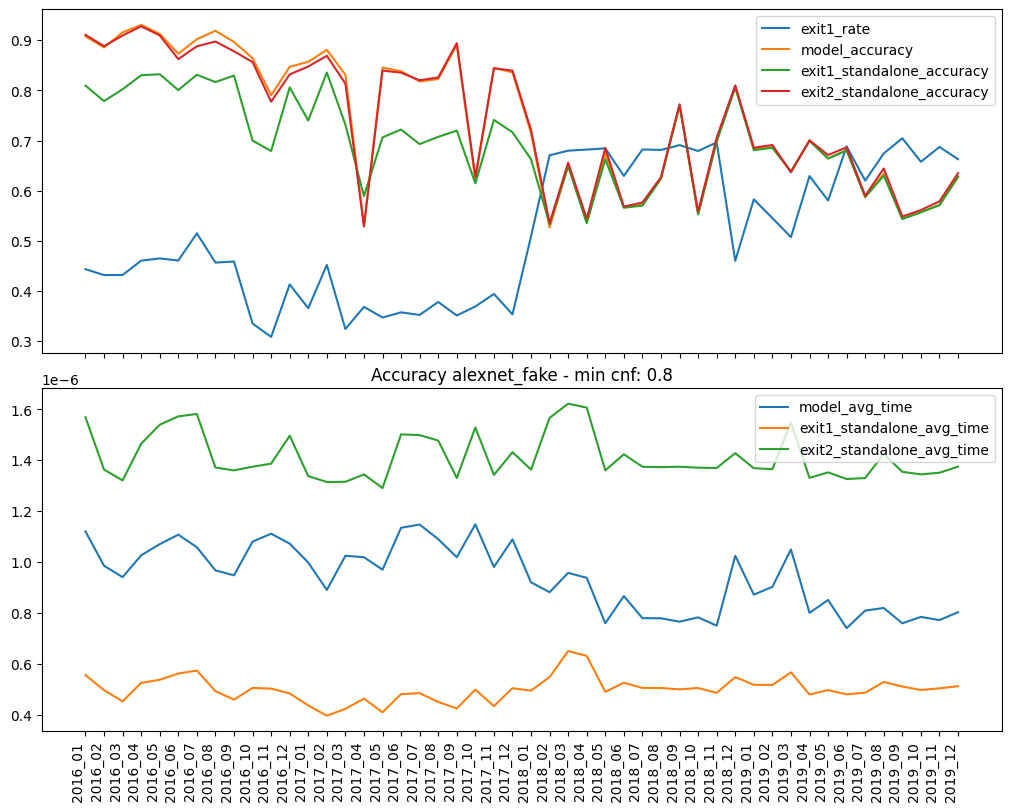

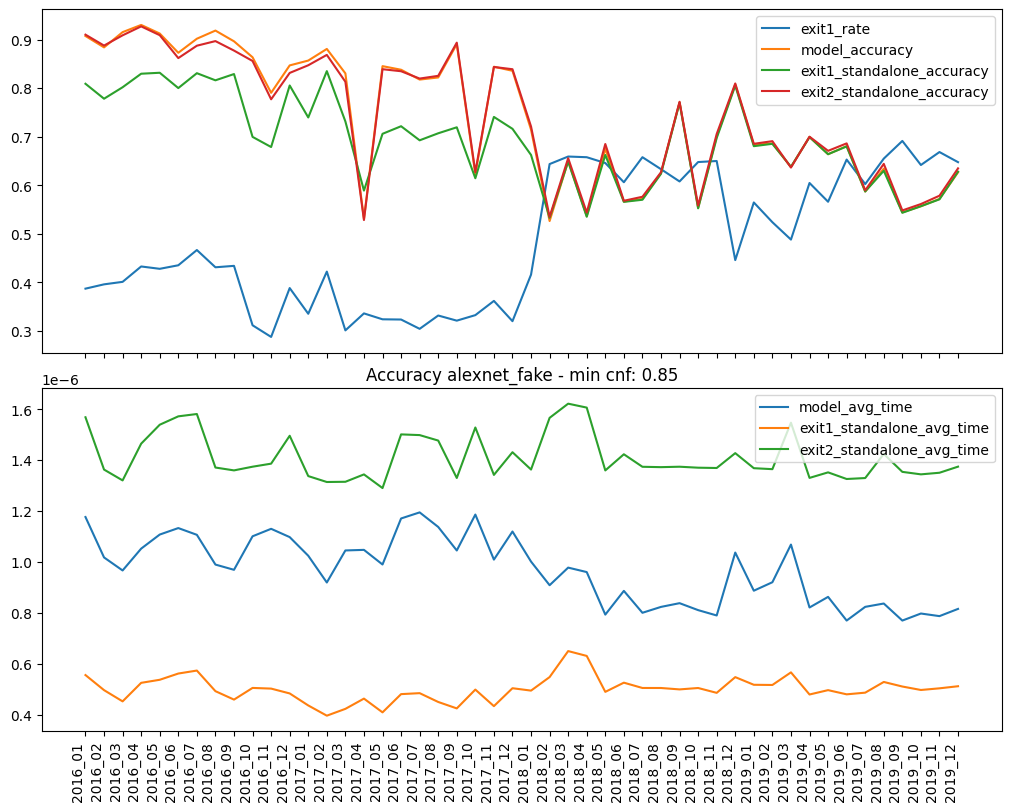

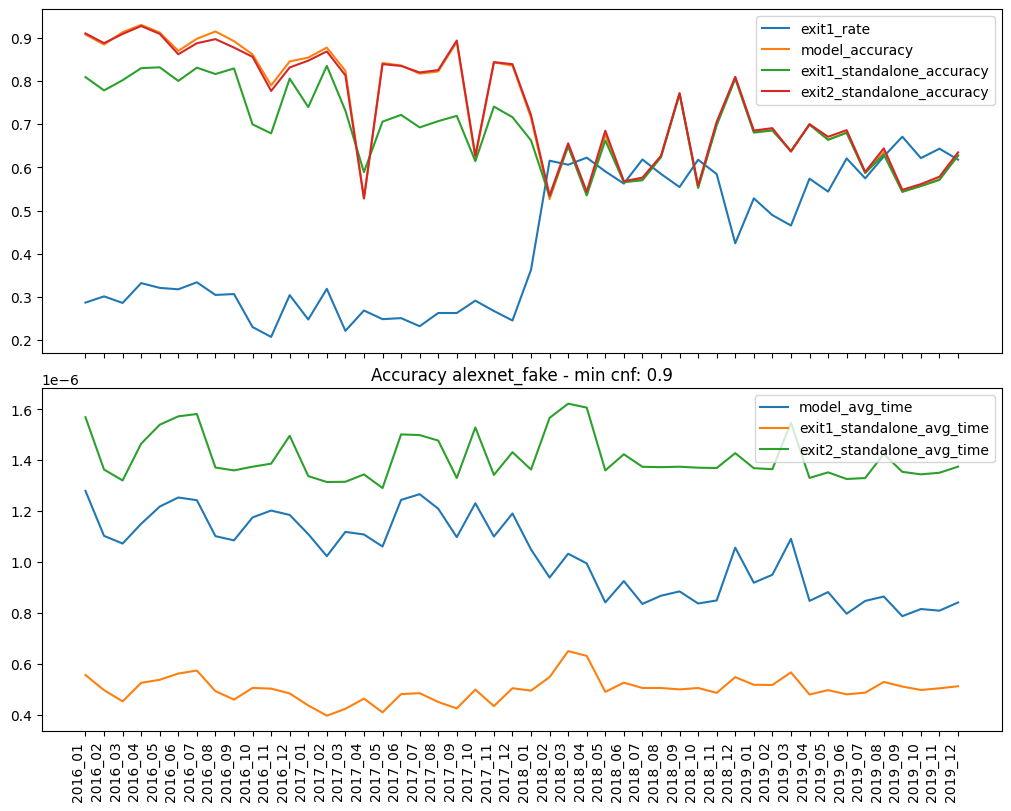

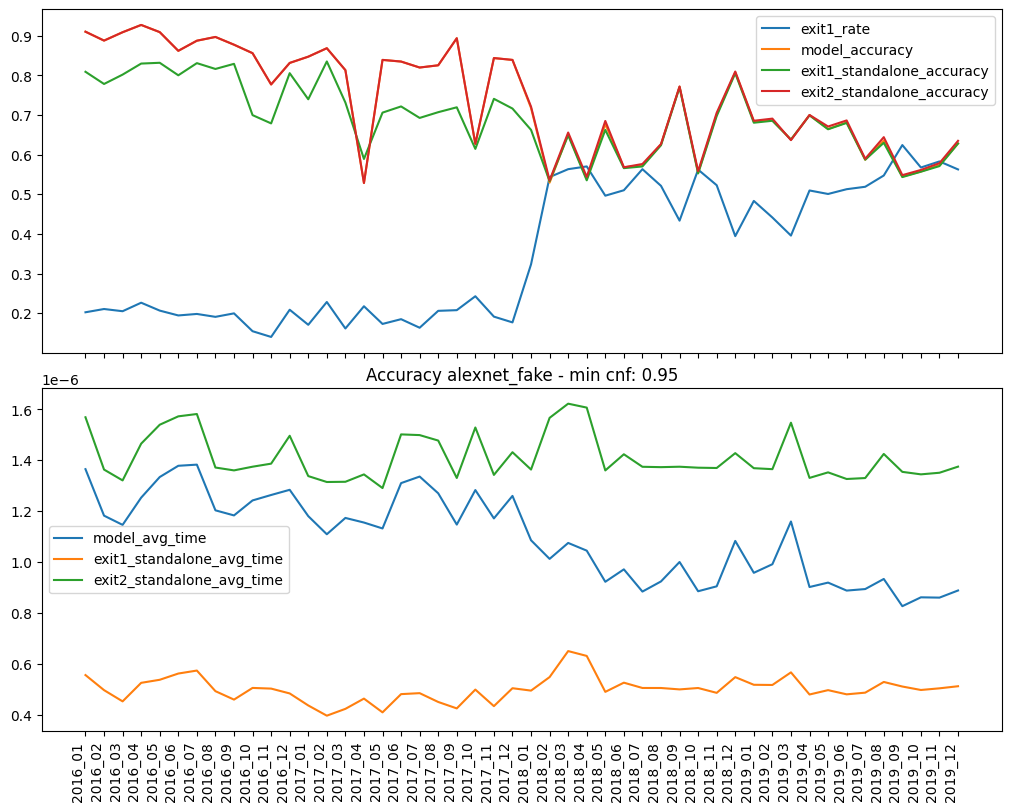

In [151]:
for cnf in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    data = process_data(alexnet_dfs, 'alexnet_fake', min_cnf=cnf)
    plot(data)